# BLS MLflow Example Notebook 2- Scikit-Learn, Random Forests, & SHAP

*Remy Stewart, BLS Civic Digital Fellow Summer 2022*

# 1.0 Introduction
This example notebook builds from the first notebook that comprehensively overviews the MLflow Python API as intergrated with the Scikit-learn library by spotlighting how MLflow can support the tracking of visualizations and model interpretability metrics. Opening up the "black box" of ML models regarding what features within data are most influential towards model predictions is a key initiative for data science within the BLS and throughout the applied ML community. 

This notebook highlights MLflow's ability to preserve artifacts that promote transparency and translating of ML model results for stakeholders beyond fellow data scientists. It spotlights a Random Forest classifier which is an  algorithm where the collection of individual decision trees that vote on potential classification labels can be directly visualized to understand how each tree processed different subsamples of the data & features to delineate class membership groups. Additionally, this example demonstrates how the SHAP (SHapley Additive exPlanation) library supports the thorough interpretation of how individual features impact the model's decision making within classification. We will therefore explore how class objects and techniques from SHAP can be logged and preserved within MLflow.


## 1.1 Data & Model Goals
The public data featured in this notebook is sourced from the Mine Safety and Health Administration (MSHA). It records incidents where mine workers have incurred a bodily injury and the provided narrative regarding what caused the injury. We will build a model to classify which body part was harmed based on the narrative text descriptions. While the MSHA data originally includes 46 unique injury categories, I have truncated the data to focus on the 8 most occuring body part labels which represent 63% of the original narrative records. This is a multiclassification task in that each MSHA narrative the model will be trained and tested on has been coded with one of the 8 injury labels.

# 2.0 Set-Up

Let's install SHAP if you're running this notebook separate from the `bls-mlflow` environment associated with this library. We're also going to employ the visualization power of the Seaborn package along with Matplotlib, as well as bring in Scikit-learn and MLflow modules designed to support Random Forest based modeling and SHAP intergration respectively. 

In [ ]:
# Will come pre-installed in the bls-mlflow conda environment
#!pip install shap

In [1]:
# Standard Modules 
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tempfile
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Sklearn Modules
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import plot_tree, export_text

# MLFlow Modules
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# SHAP module
import shap

# Helper functions
import pyfiles

sns.set()
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /ext/home/stewart_r/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We'll establish our connection to the remote BLS MLflow tracking server, set a new experiment name for our Random Forest classification of MSHA data, and initialize our model run to begin recording our workflow within MLflow. 

In [ ]:
mlflow.set_tracking_uri("http://<Remote IP>:<Port>")
mlflow.get_tracking_uri()

In [3]:
mlflow.set_experiment('rf-msha-experiment')

<Experiment: artifact_location='mlflow-artifacts:/12', experiment_id='12', lifecycle_stage='active', name='rf-msha-experiment', tags={}>

In [ ]:
run = mlflow.start_run(run_name="rfshap_test")
print(f"Started run {run.info.run_id}")

# 3.0 Data Preprocessing & EDA

We can load in the MSHA data from our designated data folder within this repository and then perform standard cleaning of the narrative text regarding removing punctuation, numbers, and common stopwords.

In [5]:
msha_df = pd.read_csv("../data/msha_truncated.csv")
msha_df

,INJ_BODY_PART,NARRATIVE
0,SHOULDER,Cleaning Gabion Grizzly Rocks get Jammed emply...
1,SHOULDER,Injured walking pit area stepped fallen tree b...
2,ANKLE,Contractor employee working carpenter miss ste...
3,FINGER(S),The employees finger pinched toe board Gallowa...
4,MULTIPLE,The employee stated rock fell top striking inj...
...,...,...
25937,SHOULDER,Spotted roller catwalk South Mains B Transfer ...
25938,FINGER(S),EE trying loosen bolt remove leads motor The b...
25939,FINGER(S),Moving Eimco surface diesel shop pinched left ...
25940,SHOULDER,Miner scaling frozen mud agglomerator struck c...


In [6]:
def narrative_cleaner(msha_df):
    class_labels = pd.unique(msha_df['INJ_BODY_PART'])

    stopwords_list = stopwords.words('english')

    # Removing punctation, numbers, & stopwords
    msha_df['NARRATIVE'] = msha_df['NARRATIVE'].str.replace(r'\d+', '', regex=True)
    msha_df['NARRATIVE'] = msha_df['NARRATIVE'].str.replace(r'[^\w\s]+', '', regex=True)
    msha_df['NARRATIVE'] = msha_df['NARRATIVE'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))
    
    return msha_df, class_labels

msha_df, class_labels = narrative_cleaner(msha_df)

## 3.1 Logging Multiclass Frequencies

One of the first componenets of model performance interpretation we'd be interested in understanding starts before we've even initialized a model. Knowing the prevalence of each of our eight classes across our data set is key to identifying how class imbalances may impact our model's behavior and can guide us towards using strategies such as class balancing and ensemble models to mitigate ML models' baseline tendency to perform the strongest on the most commonly occuring classes at the expense of the least common. 

Pandas' `value_counts` method is a great tool to create a DataFrame of record occurances by class. However, Mlflow does not support preserving Pandas DataFrames as individual artifacts. A helpful technique to approximate a DataFrame of the count of records associated with each injury code is to save the generated DataFrame as an HTML file which MLflow can preserve and visually represent in its artifact storage. We achieve this in the following code block where we store the generated HTML file within a temporary directory:

In [7]:
count_df = pd.DataFrame(msha_df['INJ_BODY_PART'].value_counts())
count_df.index.name = 'Body Part'
count_df.rename(columns={'INJ_BODY_PART':'Counts'}, inplace=True)

tempdir = tempfile.mkdtemp()
value_counts_html = os.path.join(tempdir, "value_counts.html")
count_df.to_html(value_counts_html)
mlflow.log_artifact(value_counts_html)

Here's what the stored Pandas DataFrame as an HTML file looks like in the Artifact section of our model run within the remote MLflow UI at `http://<Remote IP>:<Port>`:

![valcounts.png](../imgs/valcounts.png)

It's not quite as visually aesthetic as a DataFrame object, but it certainly serves our purposes of retaining all of the value counts across the injury label classes within one table. These class value counts can be converted into a Seaborn `countplot` as well and logged via `mlflow.log_figure`, which provides a helpful chart comparison of the numeric values we tracked within the HTML file.  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


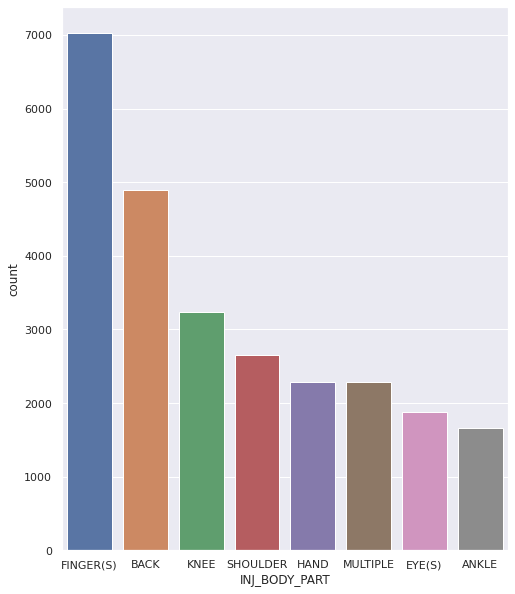

In [8]:
plt.figure(figsize = (8,10))
countplot = sns.countplot(msha_df['INJ_BODY_PART'], order = msha_df['INJ_BODY_PART'].value_counts().index)
fig = countplot.get_figure()
mlflow.log_figure(fig, 'count_plot.png')

## 3.2 Dataset Splitting & Vectorization

We call the `split_and_encode` method from our repository's helper file to split 78% of the records set aside for training, 20% for validation/testing, and 2% for generating predictions on after logging and reloading our saved model from MLflow. We additionally record the training and test set size as logged parameters as well as preserve an object of the words included in our vectorized narrative text for future use. 

In [9]:
narr_train, narr_test, inj_train, inj_test, narr_pred, text_vectorizer = pyfiles.helpers.split_and_encode(msha_df, 'NARRATIVE')

mlflow.log_param("Training Data Size", inj_train.shape[0])
mlflow.log_param("Testing Data Size", inj_test.shape[0])

feature_names = text_vectorizer.get_feature_names_out()

We log our generated TF-IDF vectorizer of the narrative text as a pickle file within MLflow as well. 

In [10]:
vectorizer_pickled = os.path.join(tempdir, "tfidf_vectorizer.pkl")
pickle.dump(text_vectorizer, open(vectorizer_pickled, 'wb'))    
mlflow.log_artifact(vectorizer_pickled)

# 4.0 Modeling via Random Forests
We're now ready to initialize our Random Forest classifier towards our multiclass labeling task. Random Forests are an ensemble method that builds from decision trees that are inherently one of the most interpretation-friendly ML algorithms. Random Forests reduce some of this baseline interpretability of decision trees since their underlying bootstrap aggregation (bagging) technique involves creating multiple trees that each differ in the bootstrapped subsample and features they produce node splits on. 

This trade-off between greater complexity that reduces immediate interpretability is rationalized by the overall increased robustness of Random Forests towards avoiding overfitting on the training data and producing more robust predictions towards class membership. They remain quite interpretable at the micro-level in that each fitted tree within the forest can be individually reviewed regarding what features it selected to produce class predictions. It's not practical to evaluate each created tree given that Random Forests commonly produce over a hundred separate trees, but the fact that it's still quite easy to visually inspect individual trees makes this algorithm a great choice for balancing interpretability with predictive performance. 

Let's walk through the components of the following training function. 
- We'll employ a cross-validation grid search with 3 k-folds to identify our best-performing model regarding two of the many hyperparameters associated with Random Forests.`num_estimators` refers to the number of individual trees fitted to produce classification votes on the narrative text. `max_depth` sets the depth the algorithm is allowed to split the data upon with respective features until producing its final leaf node class predictions. 
- We set the `RandomForest` object itself to have `class_weight='balanced'` given our imbalanced injury label classes, log the parameters of the best-fitting model following the hyperparameter search, generate predictions on the test set, and then save the best-performing model via `mlflow.sklearn.log_model` with an inferred signature of input and output data and a name for the Model Registry. 
- We compute our standard accuracy, precision, recall, and F1 scores for classification. We additionally identify the 15 word tokens that are model identified as most influential for predicting class memebership and store these words as parameters within MLflow. 
- `classification_report` is a helpful Scikit-learn method to be able to compare model performance across all of our model classes. Since its output is similar to a Pandas Dataframe, we employ a HTML conversion approach for the `classification_report` output as we used for the label value counts earlier within this walkthrough to store its results within MLflow as a table artifact. 
- We conclude the run by creating a confusion matrix of the classification results via seaborn's `heatmap` and store the created figure, this Jupyter notebook file, and our helper function Python file all within our model run's artifact store. 

In [16]:
def model_run(narr_train, narr_test, inj_train, inj_test):
    grid_params = {"n_estimators":[50, 100, 150], "max_depth":[3,5]}
        
    r_forest = RandomForestClassifier(class_weight='balanced', n_jobs=2, random_state=607)
    cross_val = GridSearchCV(r_forest, grid_params, scoring='f1_micro', cv=3)
    mlflow.log_params(cross_val.get_params())

    cross_val.fit(narr_train, inj_train)
    mlflow.log_params(cross_val.best_params_)
        
    # Estimate with best performing model
    final_model = cross_val.best_estimator_
    probabilities = final_model.predict(narr_test)
    
    signature = mlflow.models.infer_signature(narr_train, probabilities)
    mlflow.sklearn.log_model(final_model, "rf_model", conda_env="../conda.yaml", signature=signature, registered_model_name="rf_msha")
    
    accuracy_score = metrics.accuracy_score(inj_test, probabilities)
    prf_micro = pyfiles.helpers.prf_to_dict(metrics.precision_recall_fscore_support(inj_test, probabilities, average="macro"), average="macro")
    mlflow.log_metric("Accuracy", accuracy_score)
    mlflow.log_metrics(prf_micro)
    
    top15 = [val for val in (np.argsort(final_model.feature_importances_)[:-15:-1])]
    name_top15 = [val for val in feature_names[top15]]
    mlflow.log_param("15 Most Important Words for Classification:", name_top15)
    print("15 Most Important Words for Classification: ", name_top15)

    # Generating classification report and saving confusion matrix results  
    print("\nClassification Results: \n", metrics.classification_report(inj_test, probabilities, target_names=class_labels))
    
    classification_report_dict = metrics.classification_report(inj_test, probabilities, target_names=class_labels, output_dict=True)
    temp_classification_path = os.path.join(tempdir, "classification_report.html")
    pd.DataFrame(classification_report_dict).transpose().to_html(temp_classification_path)
    mlflow.log_artifact(temp_classification_path)
    
    cm_base_results = metrics.confusion_matrix(inj_test, probabilities)
    
    fig, ax = plt.subplots(figsize=(12,8))
    confusion_matrix = sns.heatmap(cm_base_results, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    conmatrix_fig_path = os.path.join(tempdir, 'confusion_matrix.png')
    fig.savefig(conmatrix_fig_path)
    mlflow.log_artifact(conmatrix_fig_path)
    mlflow.log_artifact("sklearn_rf_shap_example_2.ipynb")
    mlflow.log_artifact("./pyfiles/helpers.py")
    
    return final_model

Registered model 'rf_msha' already exists. Creating a new version of this model...
2022/08/11 07:37:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: rf_msha, version 4
Created version '4' of model 'rf_msha'.


15 Most Important Words for Classification:  ['ankle', 'hand', 'back', 'knee', 'eye', 'finger', 'shoulder', 'glasses', 'neck', 'lower', 'twisted', 'stitches', 'index', 'palm']

Classification Results: 
               precision    recall  f1-score   support

    SHOULDER       0.86      0.92      0.89       328
       ANKLE       0.86      0.87      0.86       985
   FINGER(S)       0.87      0.97      0.92       402
    MULTIPLE       0.96      0.84      0.89      1400
        BACK       0.60      0.85      0.71       432
        HAND       0.95      0.90      0.92       626
        KNEE       0.56      0.53      0.55       454
      EYE(S)       0.87      0.83      0.85       562

    accuracy                           0.84      5189
   macro avg       0.82      0.84      0.82      5189
weighted avg       0.85      0.84      0.84      5189



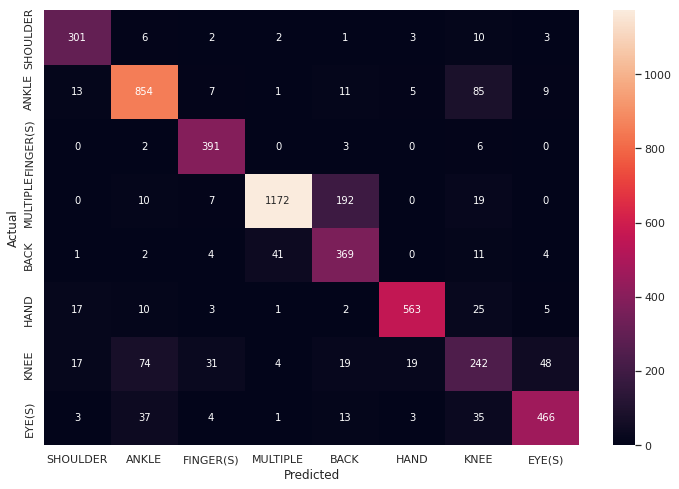

In [17]:
final_model = model_run(narr_train, narr_test, inj_train, inj_test)

## 4.1 Interpreting Model Results 

This output gives us lots of great information regarding our model's performance on each of the classes overall as well as towards what points the model was prone to misclassification. We see that certain classes such as the FINGER(S) and HAND injury label our Random Forest classifier overall performed quite well on, while it contrastingly struggled more with the KNEE class. Rviewing the confusion matrix demonstrates that narratives whose true injury label was KNEE were the most likely to be missclassified as ANKLE or EYE(S). 

Additionally, there's a few classes within the classification report that report higher recall values over precision such as BACK and FINGERS, which implies the model is strugging with false positives for these classes. Concurrent high precision but lower recall for the MULTIPLE and HAND classes implies that false negatives are the challenge points for our model regarding correctly classifying these labels. 

Here's how our classication report looks stored as a HTML table within MLflow: 

![classreport.png](../imgs/classreport.png)

These outputs are all essential tools for digging into the details of our model's performance, and they've all been successfully logged within MLflow for preserved reference. There are a few more great features affiliated with tree algorithms within Scikit-learn for us to add to our suite of visuals supporting model performance interpretation as well. The first is the `plot_tree` method, which as the name implies allows us to see the split decision points of our Random Forest classifier via an actual tree structure. 

Since the Random Forest algorithm involves an ensemble of trees, we'll just focus on visualizing the first fitted tree within the ensemble at the 0 index. Our `tree_visualization` function below creates the tree visualization, truncates the text output to support readability, and then stores the tree plot as an MLflow artifact.   

In [18]:
def tree_visualization(final_model, feature_names, class_labels):
    
    def replace_text(value):
        if type(value) == matplotlib.text.Annotation:
            text = value.get_text()
            text = re.sub("\nvalue[^$]*class","\nclass", text)
            value.set_text(text)
        return value

    fig, ax = plt.subplots(figsize = (15,15), dpi=500)
    plot_tree(final_model, ax=ax, fontsize=9, feature_names=feature_names, class_names=class_labels, 
                    precision=0, filled = True)
    ax.properties()['children'] = [replace_text(val) for val in ax.properties()['children']]
    tree_fig_path = os.path.join(tempdir, "decision_tree.png")
    plt.savefig(tree_fig_path)
    mlflow.log_artifact(tree_fig_path)
    fig.show()

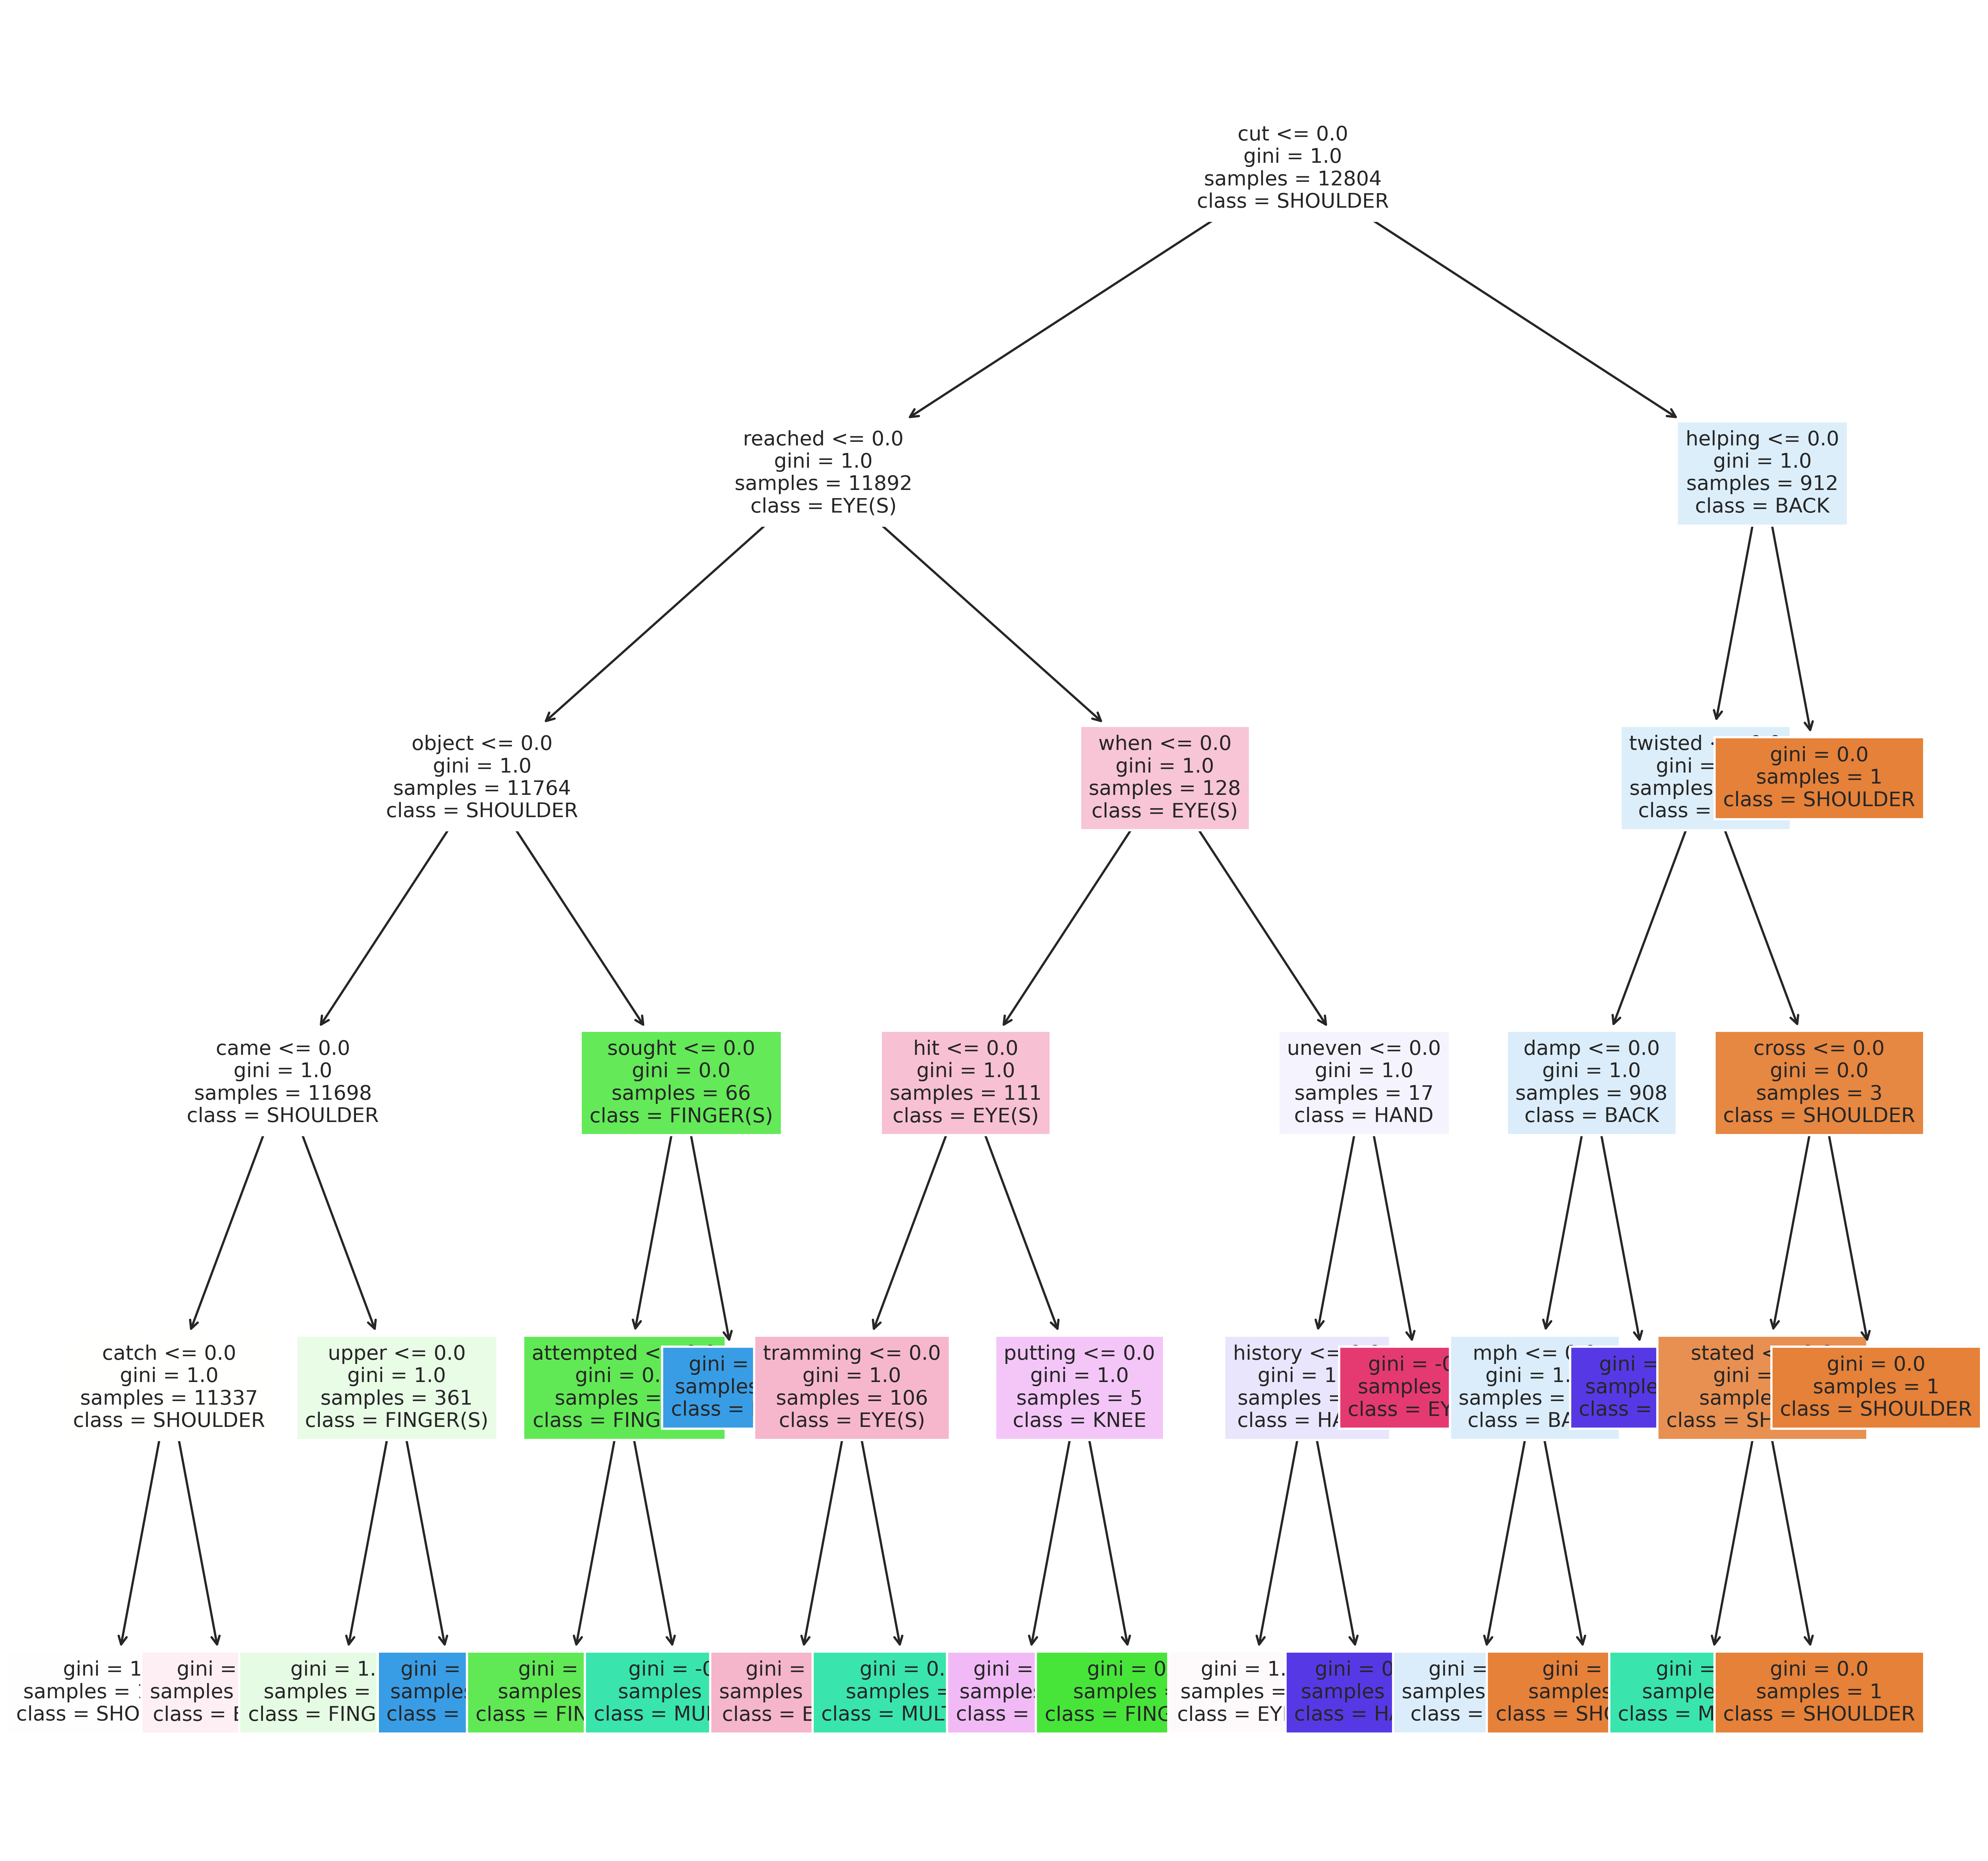

In [19]:
tree_visualization(final_model[0], feature_names, class_labels)

The best-performing `max_depth` value identified within the cross-validation grid search of our model was 5 splits over 3 splits. This isn't particularly suprising when considering how a large feature space of the narrative vocabularly along with 8 different injury classes to differentiate between is likely best supported by more feature splits rather than a smaller depth. This does come with the trade-off of a more complex tree particularly at greater depths that is difficult to visually represent in a small enough graph to be legible without node values inevitably overlapping each other. 

Scikit-learn's `export_text` method for tree algorithms is a text alternative to the tree visualization that will support our understanding regarding the actual words that lead to each node split including at the deeper tree levels that overlap each other within the visual. We can use `mlflow.log_text` to preserve the text file of the tree split path of the first tree within our random forest as an artifact as well. 

In [20]:
text_report = export_text(final_model[0], feature_names=list(feature_names))
mlflow.log_text(text_report, 'text_report.txt')
print(text_report)

|--- cut <= 0.03
|   |--- reached <= 0.14
|   |   |--- object <= 0.05
|   |   |   |--- came <= 0.11
|   |   |   |   |--- catch <= 0.05
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- catch >  0.05
|   |   |   |   |   |--- class: 7.0
|   |   |   |--- came >  0.11
|   |   |   |   |--- upper <= 0.26
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- upper >  0.26
|   |   |   |   |   |--- class: 4.0
|   |   |--- object >  0.05
|   |   |   |--- sought <= 0.19
|   |   |   |   |--- attempted <= 0.08
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- attempted >  0.08
|   |   |   |   |   |--- class: 3.0
|   |   |   |--- sought >  0.19
|   |   |   |   |--- class: 4.0
|   |--- reached >  0.14
|   |   |--- when <= 0.06
|   |   |   |--- hit <= 0.11
|   |   |   |   |--- tramming <= 0.11
|   |   |   |   |   |--- class: 7.0
|   |   |   |   |--- tramming >  0.11
|   |   |   |   |   |--- class: 3.0
|   |   |   |--- hit >  0.11
|   |   |   |   |--- putting <= 0.09
|   |   |   |   | 

# 5.0 SHAP (SHapley Additive exPlanation) Values 

Now that we've established our Random Forest classifier and highlighted the Scikit-learn methods we can draw from to support model result interpretation, let's additionally consider how the SHAP library can further support us in comprehensively understanding what words within the MSHA narratives lead to our model's class predictions. 

SHAP computes the Shapley values within ML models which originate from the field of coorperative game theory. For our specific classification context, the "game" is replicating the model's output for which body part was injured with the "players" being the narrative text used as features. The SHAP library's `TreeExplainer` method calculates how much each word within the narrative influences the model's assignment across the classes. Each MSHA observation is considered its own instance of a played "game", and the final SHAP feature values per game add up to the difference between a null model with no features and the predicted values with features included. These local feature importances per observation are then summed to represent the global importance of each word across all 8 classes the model was trained on.

SHAP's `TreeExplainer` class effortlessly handles the ensemble models of our Random Forest as well. We therefore pass our `final_model` object into the `TreeExplainer` with `feature_perturbation='tree_path_dependent'` specifying that the explainer should refer to each tree's unique bootstrap generated sample splits of narrative text features to understand the probability distributions of which features were available to generate node splits on as unique to each individual tree within the collective ensemble. We can store this created `TreeExplainer` as a pickled artifact within our MLflow run. Additionally, the `shap_values` object holds the computed Shapley values produced by the fitted `TreeExplainer` on our test data set while the `expected_value` object is the global probability of class membership across the 8 injury label classes averaged across the ensembled trees within the Random Forest. 

In [21]:
explainer = shap.TreeExplainer(model=final_model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(narr_test.toarray())
expected_value = list(explainer.expected_value)

shap_pickled = os.path.join(tempdir, "shap_explainer.pkl")
pickle.dump(explainer, open(shap_pickled, 'wb'))    
mlflow.log_artifact(shap_pickled)

## 5.1 SHAP Summary Plot

One of the SHAP library's greatest features is its comprehensive suite of Shapley value visualization methods. We'll first explore `shap.summary_plot` which visualizes global feature importance across the 8 classes. SHAP distinguishes class order based on the order of class labels it encounters on the narrative test set, so we'll create a list that represents the equivalent sequence within the test set for our visualization. We pass in the `shap_values` object along with the feature and class labels and then save the produced output as a MLflow artifact. 

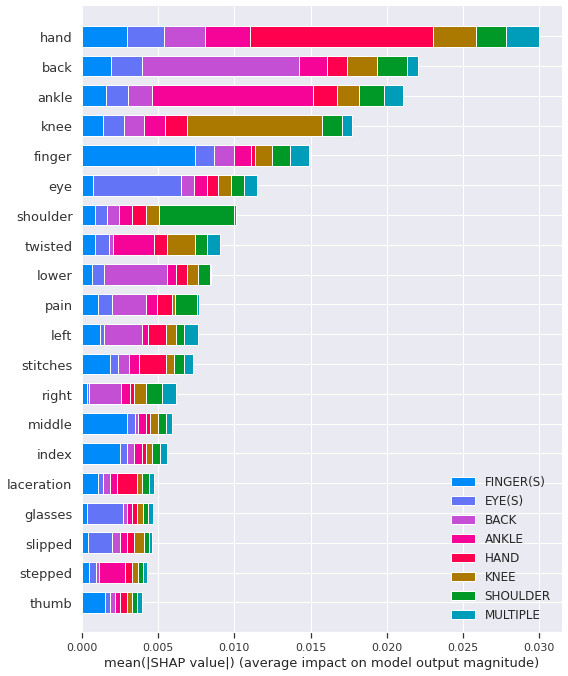

In [22]:
shap_class_labels = ['ANKLE', 'BACK', 'EYE(S)', 'FINGER(S)', 'HAND', 'KNEE', 'MULTIPLE', 'SHOULDER']
shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar', class_names=shap_class_labels, show=False)
shap_summary_path = os.path.join(tempdir, "shap_summary.png")
plt.savefig(shap_summary_path)
mlflow.log_artifact(shap_summary_path)
plt.show()

The results featured within the `summary_plot` overall make intuitive sense. "Eye" is most associated with the "EYE(S)" label, "Knee" dominates the "KNEE" class, and so on for words within the narrative text that directly refer to the injured body parts. This figure also provides some more indirect associations that expand our understanding of what words the model drawed upon across the forest of decision trees. We can see "glasses" as connected to the "EYES" class, "stepped" as linked to injured "ANKLE"s, and "index" as referring to a specific "FINGER" that was perhaps one of the most commonly injured "FINGER"s within our MSHA sample. 

## 5.2 SHAP Decision Plot 

`shap.multioutput_decision_plot` is a method that allows us to further understand how our model navigated different features to generate its injury class prediction for a single narrative record. To create a `multioutput_decision_plot`, you pass in the expected class memebership average probabilities, the computed Shapley values, the index of which data point you'd like to inspect within the test narrative set, and the class & feature names all as arguments. We'll go ahead and store this visual in MLflow as well. 

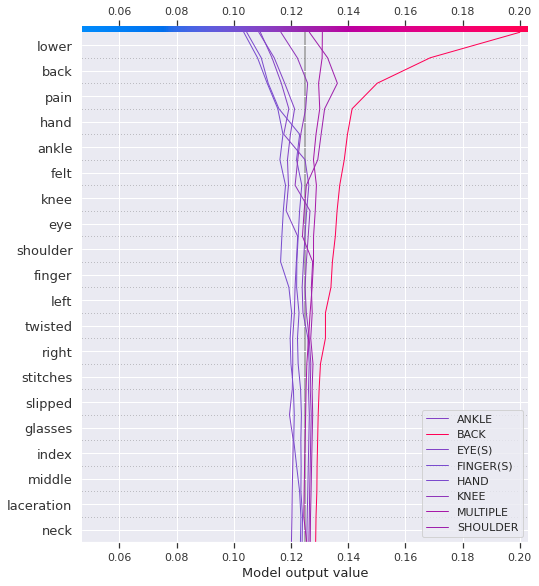

In [23]:
shap_decision = shap.multioutput_decision_plot(expected_value, list(shap_values), row_index=0, feature_names=feature_names,
                              legend_labels=shap_class_labels, legend_location='lower right', show=False)
shap_decision_path = os.path.join(tempdir, "shap_decision.png")
plt.savefig(shap_decision_path)
mlflow.log_artifact(shap_decision_path)
plt.show()

This record in the training set was classified into the "BACK" injury label, and starting from the bottom of the visual guides us through the model's path of considering different features towards this classification decision. Each of the lines refers to the current probability the model is computing for each potential classification label. We see that the first few words such as "neck" and "laceration" don't have much of an impact towards impacting the model's prediction. The probabilites start to change when a given decision tree designates node splits on words such as "hand" and "pain". Node splits based on "back" and "lower" are by far the most influential features towards raising the model's estimated probability of this given test sample belonging to the "BACK" label. 

We've stored a great range of tables and visualizations all focused on model interpretability within this single MLflow model run, so let's go ahead and finalize the run within the MLflow Tracking UI through passing `mlflow.end_run`.

In [24]:
mlflow.end_run()

We overall end with 8 logged figures and tables all supporting the transparent understanding of our model's performance and decision points for classification, which could likely all serve as great resources to communicate our model's design and experiment results within presentations and documentation intended for a wider BLS audience. 

# 6.0 Testing Model Predictions & SHAP Explainer 
Now that we've ended our current MLflow model run and logged our model into the Model Registry, let's verify that our model, its associated TF-IDF vectorizer, and the SHAP `TreeExplainer` can all be successfully retrieved from MLflow to be applied to our held-out prediction data set. 

We first establish a `MLflowClient()` object to facilitate our interactions with the MLflow Tracking UI. We then call the model directly by its specified path in the Model Registry and then load in our pickled vectorizer and SHAP explainer from our model's artifact storage paths. 

In [25]:
# load in the registered model, TF-IDF scalar, and SHAP explainer 
client = MlflowClient()
registered_model = mlflow.pyfunc.load_model(model_uri="models:/rf_msha/1")

tfidf_scaler_path = client.download_artifacts("<Model Path>", "tfidf_vectorizer.pkl", tempdir)
tfidf_scaler = pickle.load(open(tfidf_scaler_path, 'rb'))

shap_explainer_path = client.download_artifacts("<Model Path>", "shap_explainer.pkl", tempdir)
shap_explainer = pickle.load(open(shap_explainer_path, 'rb'))

We can see below that our TF-IDF vectorizer is able to transform our held-out prediction data, and that our model can easily produce an array of predictions on the 416 prediction records. 

In [26]:
narr_predict_vectorized = tfidf_scaler.transform(narr_pred)
narr_predict_vectorized

<416x12118 sparse matrix of type '<class 'numpy.float64'>'
	with 7210 stored elements in Compressed Sparse Row format>

In [27]:
registered_model.predict(narr_predict_vectorized)

array(['FINGER(S)', 'SHOULDER', 'SHOULDER', 'MULTIPLE', 'EYE(S)', 'ANKLE',
       'KNEE', 'ANKLE', 'SHOULDER', 'FINGER(S)', 'BACK', 'KNEE', 'BACK',
       'SHOULDER', 'MULTIPLE', 'KNEE', 'MULTIPLE', 'FINGER(S)', 'ANKLE',
       'KNEE', 'HAND', 'HAND', 'HAND', 'FINGER(S)', 'EYE(S)', 'ANKLE',
       'FINGER(S)', 'BACK', 'FINGER(S)', 'BACK', 'FINGER(S)', 'KNEE',
       'BACK', 'EYE(S)', 'ANKLE', 'SHOULDER', 'FINGER(S)', 'FINGER(S)',
       'HAND', 'KNEE', 'BACK', 'FINGER(S)', 'KNEE', 'BACK', 'BACK',
       'MULTIPLE', 'HAND', 'BACK', 'BACK', 'FINGER(S)', 'BACK', 'KNEE',
       'BACK', 'EYE(S)', 'FINGER(S)', 'ANKLE', 'KNEE', 'SHOULDER',
       'FINGER(S)', 'KNEE', 'BACK', 'FINGER(S)', 'BACK', 'KNEE', 'EYE(S)',
       'MULTIPLE', 'MULTIPLE', 'BACK', 'ANKLE', 'KNEE', 'MULTIPLE',
       'SHOULDER', 'BACK', 'MULTIPLE', 'BACK', 'KNEE', 'KNEE', 'MULTIPLE',
       'BACK', 'BACK', 'HAND', 'FINGER(S)', 'FINGER(S)', 'KNEE',
       'MULTIPLE', 'SHOULDER', 'FINGER(S)', 'FINGER(S)', 'FINGER(S)',
      

We get a host of predictions automatically configured to map the numeric class codes to their associated injury labels. Let's now test whether we can produce a `multioutput_decision_plot` with our retrieved SHAP explainer on the first record of the prediction data that our model classified as belonging to the "FINGER(S)" injury label. 

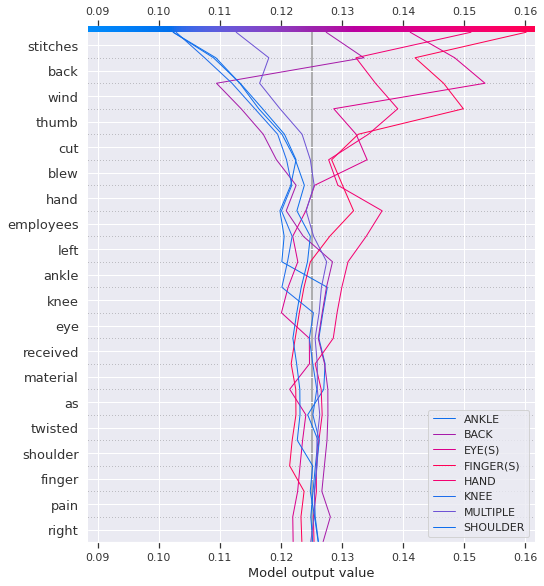

In [28]:
shap_prediction_values = shap_explainer.shap_values(narr_predict_vectorized.toarray())
shap.multioutput_decision_plot(expected_value, list(shap_prediction_values), row_index=0, feature_names=feature_names, 
                               legend_labels=shap_class_labels, legend_location='lower right')

Our retrieved explainer produces another `multioutput_decision_plot` on the first data point within our prediction set with ease. You can see within the bottom half of the plot the model overall switched this record's placement across various node splits on words such as "right" and "pain" without making significant differences in its predicted class probabilities for this record. There's actually a fair amount of uncertainty being expressed by the model at decision points such as "back" regarding this record's class membership. It appears that splits based on "stitches" being present within this record's narrative is what solidifies the model's final prediction regarding the record's class membership within the "FINGER"s class in combination with associated splitting points such as "hand" and "thumb". 

With that, we've successfully completed our MLflow-backed model experiementation workflow starting from data preprocessing, fitting our Random Forest with grid-search cross validation, interpreting its performance through both Scikit-learn and SHAP methods, and concluding by verifying its ability to predict on unseen data as loaded from our MLflow tracking server.